In [1]:
import zipfile
import os
import torch
import numpy as np
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
import torchvision.transforms as tt
from torch.utils.data import random_split
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
!pip install kaggle --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install opendatasets --upgrade --quiet

In [3]:
import opendatasets as od

In [4]:
od.download('https://www.kaggle.com/datasets/mahmoudreda55/satellite-image-classification')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: sashalai
Your Kaggle Key: ··········


100%|██████████| 21.8M/21.8M [00:01<00:00, 20.1MB/s]


In [7]:
#download dataset using kaggle API & unzip data
if os.path.exists('./satellite-image-classification'):
  print('file exists')
else:
  !kaggle datasets download mahmoudreda55/satellite-image-classification
  #with zipfile.ZipFile('./satellite-image-classification.zip', 'r') as zip_ref:
    #zip_ref.extractall('./satellite-image-classification')

file exists


In [5]:
#data directory
data_dir = './satellite-image-classification/data'

In [6]:
os.listdir(data_dir)

['water', 'cloudy', 'desert', 'green_area']

### Import dataset into Pytorch

In [7]:
dataset = ImageFolder(data_dir)

In [8]:
dataset_len = len(dataset)
dataset_len

5631

In [ ]:
#dataset classes
classes = dataset.classes
classes

['cloudy', 'desert', 'green_area', 'water']

In [ ]:
for cls in os.listdir(data_dir):
    print(cls, ':', len(os.listdir(data_dir + '/' + cls)))

cloudy : 1500
desert : 1131
green_area : 1500
water : 1500


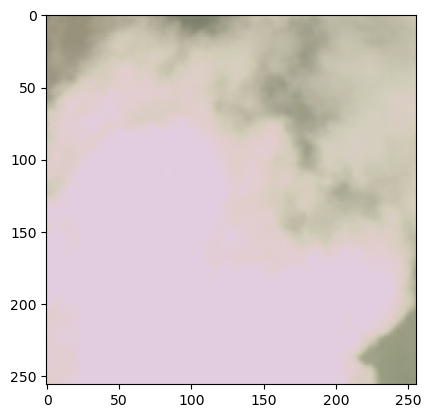

In [ ]:
img, label = dataset[0]
plt.imshow(img)

In [ ]:
random_seed = 27
torch.manual_seed(random_seed)

In [ ]:
#split into train & validation dataset
val_size = int(dataset_len * 0.1)
train_size = dataset_len - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(5068, 563)

In [ ]:
#data augmentation
train_tfms = tt.Compose([tt.Resize(64),
                         tt.RandomCrop(64, padding = 4, padding_mode = 'reflect'),
                         tt.RandomHorizontalFlip(),
                         tt.ColorJitter(brightness = 0.1, contrast = 0.1, saturation = 0.1, hue = 0.1),
                         tt.ToTensor()])

val_tfms = tt.Compose([tt.ToTensor()])

In [ ]:
train_ds = ImageFolder(data_dir, train_tfms)
val_ds = ImageFolder(data_dir, val_tfms)

In [ ]:
batch_size = 128

In [ ]:
train_dl = DataLoader(train_ds, batch_size, shuffle = True, num_workers = 3, pin_memory = True)
val_dl = DataLoader(train_ds, batch_size*2, shuffle = True, num_workers = 3, pin_memory = True)

In [ ]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize = (16, 8))
        ax.set_xticks([]); ax.set_yticks([]);
        ax.imshow(make_grid(images, nrow = 16).permute(1, 2, 0))
        break

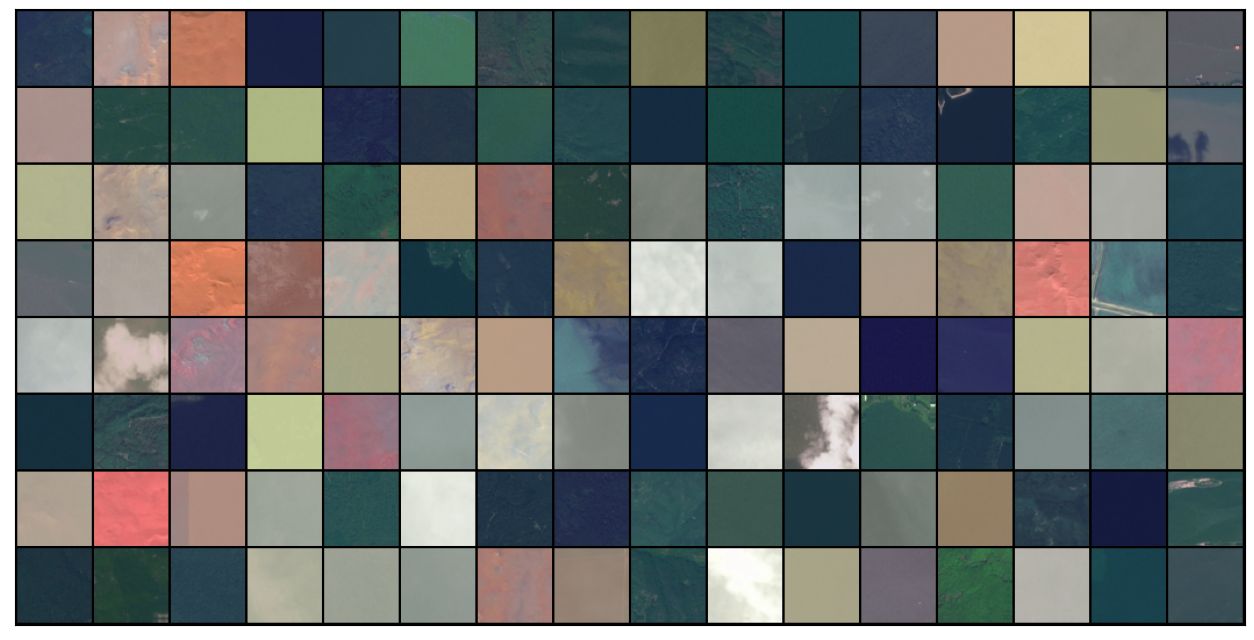

In [ ]:
show_batch(train_dl)

### Using GPU

In [ ]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking = True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
    
    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)
    
    def __len__(self):
        return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

### Defining Model

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim = 1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss
    
    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'val_loss': loss.detach(), 'val_acc': acc}
    
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

In [ ]:
def conv_block(in_channels, out_channels, pool = False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size = 3, padding = 1),
             nn.BatchNorm2d(out_channels),
             nn.ReLU(inplace = True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.conv1 = conv_block(in_channels, 32)
        self.conv2 = conv_block(32, 128, pool = True)
        self.conv3 = conv_block(128, 256)
        self.res1 = nn.Sequential(conv_block(256, 256), conv_block(256, 256))
        
        self.conv4 = conv_block(256, 512, pool = True)
        self.conv5 = conv_block(512, 256)
        self.conv6 = conv_block(256, 128, pool = True)
        self.res2 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        
        self.classifier = nn.Sequential(nn.AdaptiveMaxPool2d(1),
                                        nn.Flatten(),
                                        nn.Dropout(0.2),
                                        nn.Linear(128, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.res1(out) + out
        out = self.conv4(out)
        out = self.conv5(out)
        out = self.conv6(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [ ]:
model = to_device(ResNet(3, 4), device)
model

ResNet(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
   

### Training

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
    
def fit_one_cycle(epochs, max_lr, train_loader, val_loader, weight_decay = 0, grad_clip = None, opt_func = torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    optimizer = opt_func(model.parameters(), max_lr, weight_decay = weight_decay)
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs = epochs, steps_per_epoch = len(train_loader))
    
    for epoch in range(epochs):
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
                
            optimizer.step()
            optimizer.zero_grad()
            
            lrs.append(get_lr(optimizer))
            sched.step()
            
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
history = [evaluate(model, val_dl)]
history

[{'val_loss': 1.3837921619415283, 'val_acc': 0.26637423038482666}]

In [ ]:
epochs = 10
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [ ]:
%%time
history += fit_one_cycle(epochs, max_lr, train_dl, val_dl, grad_clip = grad_clip, weight_decay = weight_decay, opt_func = opt_func)

Epoch [0], last_lr: 0.00273, train_loss: 0.5850, val_loss: 3.0059, val_acc: 0.6587
Epoch [1], last_lr: 0.00757, train_loss: 0.3763, val_loss: 1.1695, val_acc: 0.6090
Epoch [2], last_lr: 0.01000, train_loss: 0.4015, val_loss: 0.5832, val_acc: 0.7881
Epoch [3], last_lr: 0.00950, train_loss: 0.3942, val_loss: 0.8553, val_acc: 0.7494
Epoch [4], last_lr: 0.00812, train_loss: 0.2701, val_loss: 2.8814, val_acc: 0.5763
Epoch [5], last_lr: 0.00611, train_loss: 0.1999, val_loss: 1.2563, val_acc: 0.7819
Epoch [6], last_lr: 0.00389, train_loss: 0.1876, val_loss: 0.1663, val_acc: 0.9402
Epoch [7], last_lr: 0.00188, train_loss: 0.1604, val_loss: 0.3899, val_acc: 0.8554
Epoch [8], last_lr: 0.00050, train_loss: 0.1242, val_loss: 0.0926, val_acc: 0.9686
Epoch [9], last_lr: 0.00000, train_loss: 0.1225, val_loss: 0.0847, val_acc: 0.9716
Wall time: 4min 7s


In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

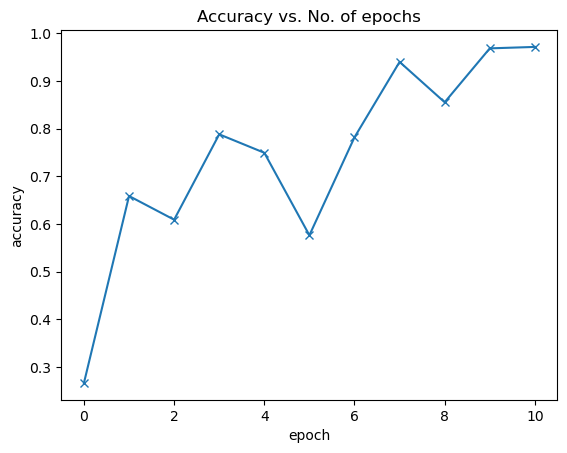

In [ ]:
plot_accuracies(history)

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

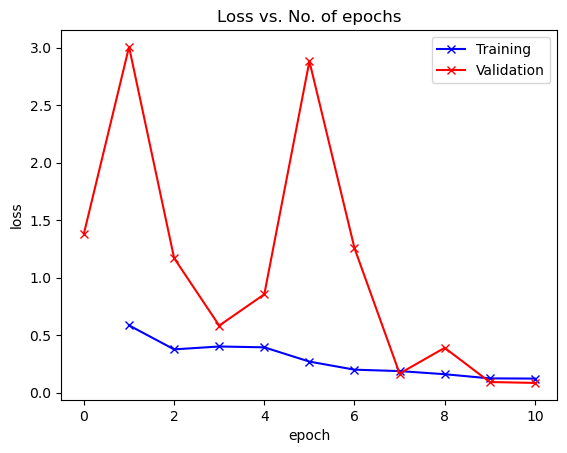

In [ ]:
plot_losses(history)

In [ ]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

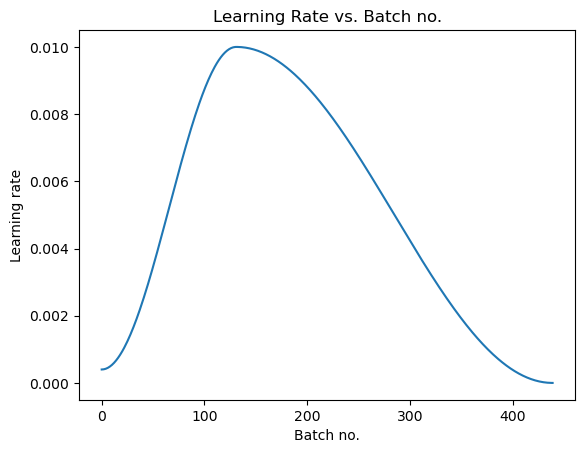

In [ ]:
plot_lrs(history)

### Testing 

In [ ]:
def predict_image(img, model):
    xb = to_device(img.unsqueeze(0), device)
    yb = model(xb)
    _, preds = torch.max(yb, dim = 1)
    return train_ds.classes[preds[0].item()]

Label: water , Predicted: water


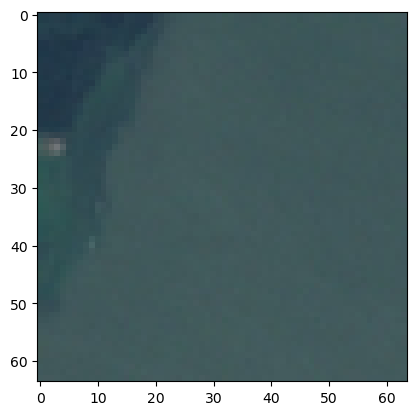

In [ ]:
img, label = val_ds[4325]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model))

Label: cloudy , Predicted: cloudy


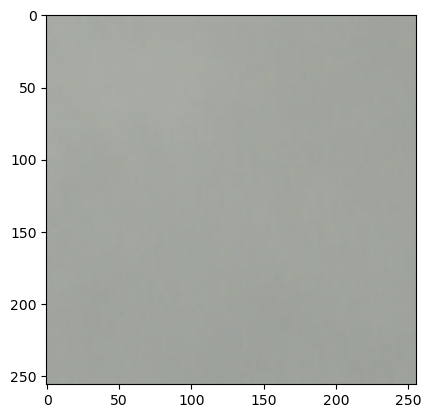

In [ ]:
img, label = val_ds[327]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model))

Label: water , Predicted: water


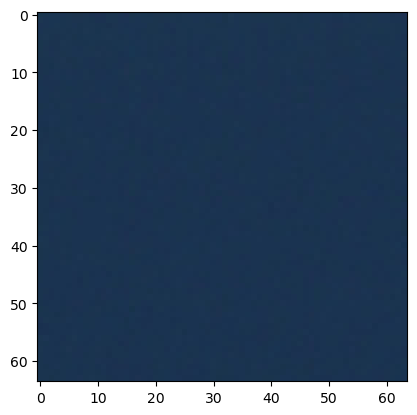

In [ ]:
img, label = val_ds[5000]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model))

### Save Model

In [ ]:
torch.save(model.state_dict(), 'satellite-image-classification.pth')